# Assignment 3

## Instructions
- Run this notebook on ```Google Colab(preferable)```
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells. 

## Packages Used
- sklearn [link](https://scikit-learn.org/)
- Keras [link](https://keras.io/guides/)

## Submission
- Rename the notebook to `<roll_number>_Assignment3_Q3.ipynb`.


## Question 3
Fake news is a widespread problem and there are many methods for combating it.
You have to build a fake news detection system using a ML model. Train any ML model (ANN, LSTM) over the given Dataset.
The dataset has short statements spoken by people and has the meta-information and corresponding label for those sentences. 
Your target is label column which has 6 labels(in the increasing order of truthfullness): pants-fire, false, barely-true, half-true, mostly-true, true.

The features are 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'venue' and the target is column "label".

The statement is made by speaker whose job, party are given along with 6 columns which are an account of the  type of news(labels) the person has shared before. 
The person who has shared fake content before is likely to share it in future and this can be accounted by the ML model as a feature. Column barely_true_c contains how many barely_true news has the speaker shared (and so is with column X_c, value of X_c is number of X the person shared).


You have to perform two tasks:
* task1: Binary classification <br>
Classify the given news as true/false. Take the labels pants-fire, false, barely-true as false and rest (half-true, mostly-true, true) as true.
* task2: Six-way classification <br>
Classify the given news into six-classes "pants-fire, false, barely-true, half-true, mostly-true, true".

For each of the tasks:
1) Experiment with depth of network and try to fine-tune hyperparameters reporting your observations. <br>
2) Report the accuracy, f1-score, confusion matrix on train, val and test sets. <br>
3) Experiment with bag-of-words, glove and bert embeddings(code given in the below notebook) and report results. <br> Comment on what is the affect of embedding on the results.

The pre-processing code is provided, you need to write the training and test.

Note: You are supposed to train on trainset, fine-tune on val and just eval on test set. If found that you trained on val/test sets, the penalty will be incurred.

In [4]:
import requests

In [5]:
r = requests.get('https://nlp.stanford.edu/data/glove.6B.zip', allow_redirects=True)


In [6]:
r

<Response [200]>

In [7]:
with open('glove.6B.200d.zip', 'wb') as f:
  f.write(r.content)

In [8]:
!unzip "glove.6B.200d.zip" -d "glove"

Archive:  glove.6B.200d.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


In [9]:
# !pip install numpy
# !pip install tensorflow
# !pip install re
# !pip install nltk
# !pip install keras
# !pip install sklearn

In [10]:
# Importing libraries
# import numpy as np
import pandas as pd
from tensorflow import keras  #feel free to use any other library
# import numpy as np

import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import np_utils


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)


In [14]:
train = pd.read_csv('q3_data/train.csv')
val = pd.read_csv('q3_data/val.csv')
test = pd.read_csv('q3_data/test.csv')

In [15]:
# Dropping the 'id' column
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
val.drop('id', axis = 1, inplace = True)

In [16]:
train.head(5)

,label,statement,subject,speaker,job,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,venue
0,False,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,False,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15,9,20,19,2,an interview on CNN


In [17]:
# Checking the shape of data
print(train.shape)
print(val.shape)
print(test.shape)

(10269, 13)
(1284, 13)
(1283, 13)


## Clean and pre-process data
* Replace missing values
* Remove numbers and special characters
* Convert to upper-case

We experiment with two types of processing, one directly appending the other attributes like subject, job, state, party to sentence and then applying bag of words on it.

Other being encoding sentence with glove embeddings and passing just that.

In [18]:

def dataPreprocessing(data):
    '''Function for cleaning the dataset
    '''
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = statement.split()
        
        # you can experiment with any other stemmers
        ps = PorterStemmer()
        statement = [ps.stem(word) for word in statement if not word in set(stopwords.words('english'))] # Stemming the dataset and removing stopwords
        statement = ' '.join(statement)
        subject = data['subject'][x].replace(',', ' ')
        speaker = data['speaker'][x]
        job = data['job'][x].lower()
        # job = job.replace(' ', '-')
        state = data['state'][x].lower()
        party = data['party'][x].lower()
        corpus.append(statement + ' '  + subject + ' ' + job + ' ' + state + ' ' + party)
    return corpus

In [19]:
x_train = dataPreprocessing(train)
x_val = dataPreprocessing(val) 
x_test = dataPreprocessing(test) 

In [20]:
len(x_train), len(x_val), len(x_test)

(10269, 1284, 1283)

In [21]:
corpus = x_train + x_val + x_test

## Using bag-of-words embedding


In [22]:
num_features = 8000

In [23]:
# Converting the corpus into bag-of-words
cv = CountVectorizer(max_features = num_features)
X = cv.fit_transform(corpus).toarray()

In [24]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
X.shape

(12836, 8000)

In [26]:
train.columns

Index(['label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
       'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c', 'venue'],
      dtype='object')

In [27]:
# Selecting the columns 'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c'
label_cols = ['barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c']
x_train2 = train[label_cols]
x_val2 = val[label_cols]
x_test2 = test[label_cols]

In [28]:
# Stacking x_train and x_train2 horizontally
x_train_bow = np.hstack((X[:len(x_train)], x_train2))
x_val_bow = np.hstack((X[len(x_train):len(x_train)+len(x_val)], x_val2))
x_test_bow = np.hstack((X[len(x_train)+len(x_val):], x_test2))

In [29]:
x_train_bow.shape

(10269, 8005)

## Use of Glove Embedding


download glove embeddings from 'https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip'
and place in your current working folder


In [30]:
emmbed_dict = {}
with open('glove/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector


In [31]:
emmbed_dict['oov'] = np.zeros(200)

In [32]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 4.0 MB 8.8 MB/s 
     |████████████████████████████████| 1.2 MB 9.8 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 514 kB/s 
     |████████████████████████████████| 895 kB 52.1 MB/s 
     |████████████████████████████████| 596 kB 31.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=d8ce18a41564b6073ad5427365e0aa61e385f4cff2823af2221c5b0297807bdc
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [33]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [51]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def dataPreprocessing_glove(data):
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = word_tokenize(statement)

        embed_statement = []
        for w in statement:
            if w in emmbed_dict:
                embed_statement.append(emmbed_dict[w])
            else:
                embed_statement.append(emmbed_dict['oov'])
         
        diff = 40 - len(embed_statement)
        if diff < 0:
            embed_statement = embed_statement[:40]
        elif diff > 0:
            for i in range(diff):
                embed_statement.append(emmbed_dict['oov'])
        

        # bonus: Think how you can encode the below features(hint: look upon label encoding or training your own word2vec or any other embedding model)
    
#         subject = data['subject'][x].replace(',', ' ')
#         speaker = data['speaker'][x]
#         job = data['job'][x].lower()
#         # job = job.replace(' ', '-')
#         state = data['state'][x].lower()
#         party = data['party'][x].lower()
        corpus.append(embed_statement)
    
    return np.array(corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
x_train_glove = dataPreprocessing_glove(train)
x_val_glove = dataPreprocessing_glove(val) 
x_test_glove = dataPreprocessing_glove(test) 

In [54]:
x_train2.shape

(10269, 5)

In [55]:
x_train_glove = np.hstack((x_train_glove.reshape(-1,40*200), x_train2))
x_val_glove = np.hstack((x_val_glove.reshape(-1,40*200), x_val2))
x_test_glove = np.hstack((x_test_glove.reshape(-1,40*200), x_test2))

## Use of bert embeddings
note: we used our pre-processed code for bow which has the attributed appended to end the end of sentence. 

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

x_train_bert = np.hstack((model.encode(x_train), x_train2))
x_val_bert = np.hstack((model.encode(x_val), x_val2))
x_test_bert = np.hstack((model.encode(x_test), x_test2))

Now use the above 3 types of embedded inputs(bow, glove, bert embeddings) for the 2 classification tasks and compare their outputs


# Six-way classification

## Preprocessing

In [ ]:
num_classes = 6
# Preprocessing function for the labels
def categorize(data):
    y = data["label"].tolist()

    # Encoding the Dependent Variable
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)

    # Converting to binary class matrix
    y = np_utils.to_categorical(y, num_classes)
    return y

In [ ]:
y_train_six_way = categorize(train)
y_test_six_way = categorize(test)
y_val_six_way = categorize(val)

Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3172447622762613958
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10638655488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4514979330799969436
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


## Model

In [ ]:
def createHexaModel(input_sample):
  model = keras.Sequential()
  model.add(keras.layers.Embedding(input_sample.shape[0], 50, input_length=input_sample.shape[1])) # , batch_size=batch_size
  model.add(keras.layers.LSTM(64))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(6, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# createHexaModel()

In [ ]:
## write your code here
# Initialize hyperparameters
# Create model
# train
# test
# report accuracy, f1-score and confusion matrix

#Bag of words

In [ ]:
x_train_bow.shape, x_val_bow.shape, x_test_bow.shape

((10269, 8005), (1284, 8005), (1283, 8005))

In [ ]:
model = createHexaModel(x_train_bow)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8005, 50)          513450    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 561,072
Trainable params: 561,072
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train_bow, y_train_six_way, validation_data=[x_val_bow, y_val_six_way], epochs=10)

Epoch 1/10
321/321 [==============================] - 346s 1s/step - loss: 1.7116 - accuracy: 0.2313 - val_loss: 1.4941 - val_accuracy: 0.3364
Epoch 2/10
321/321 [==============================] - 337s 1s/step - loss: 1.4080 - accuracy: 0.3814 - val_loss: 1.3430 - val_accuracy: 0.4011
Epoch 3/10
321/321 [==============================] - 338s 1s/step - loss: 1.3508 - accuracy: 0.4084 - val_loss: 1.3198 - val_accuracy: 0.4354
Epoch 4/10
321/321 [==============================] - 338s 1s/step - loss: 1.3320 - accuracy: 0.4186 - val_loss: 1.3081 - val_accuracy: 0.4307
Epoch 5/10
 91/321 [=======>......................] - ETA: 3:50 - loss: 1.3210 - accuracy: 0.4231

In [ ]:
history.history

{'accuracy': [0.23127859830856323,
  0.3814392685890198,
  0.40841367840766907,
  0.4186386168003082,
  0.42633166909217834,
  0.4306164085865021,
  0.43538805842399597,
  0.43918588757514954,
  0.4383094608783722,
  0.4493134617805481],
 'loss': [1.7115541696548462,
  1.4080232381820679,
  1.350752353668213,
  1.3319745063781738,
  1.3195946216583252,
  1.3035993576049805,
  1.2947049140930176,
  1.287904977798462,
  1.2832139730453491,
  1.2767143249511719],
 'val_accuracy': [0.336448609828949,
  0.4010903537273407,
  0.4353582561016083,
  0.4306853711605072,
  0.4252336323261261,
  0.43691587448120117,
  0.4291277229785919,
  0.44859811663627625,
  0.4571651220321655,
  0.4423676133155823],
 'val_loss': [1.494050145149231,
  1.343047857284546,
  1.319791316986084,
  1.3080540895462036,
  1.3118832111358643,
  1.286596417427063,
  1.2900439500808716,
  1.2805544137954712,
  1.2663538455963135,
  1.2659720182418823]}

In [ ]:
predict = model.predict(x_test_bow)

In [ ]:
predict.shape

(1283, 6)

In [ ]:
accuracy_score(np.argmax(y_test_six_way, axis=1), np.argmax(predict, axis=1))

0.4271239282930631

In [ ]:
print('Accuracy score')
accuracy_score(np.argmax(y_test_six_way, axis=1), np.argmax(predict, axis=1))

0.40374123148869834

In [ ]:
print('F1 score')
f1_score(np.argmax(y_test_six_way, axis=1), np.argmax(predict, axis=1), average='macro')

F1 score


0.40645462848062985

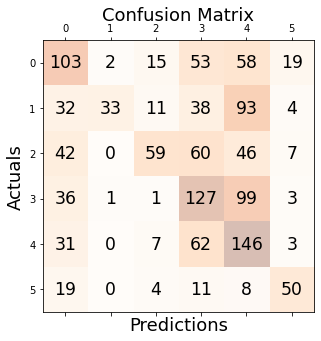

In [ ]:
conf_mat = confusion_matrix(np.argmax(y_test_six_way, axis=1), np.argmax(predict, axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#Bert embeddings

In [ ]:
x_train_bert.shape, x_val_bert.shape, x_test_bert.shape

((10269, 389), (1284, 389), (1283, 389))

In [ ]:
model = createHexaModel(x_train_bert)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:

In [ ]:
history = model.fit(x_train_bert, y_train_six_way, validation_data=[x_val_bert, y_val_six_way], epochs=10)

In [ ]:
# dir(history)

In [ ]:
history.params

{'epochs': 10, 'steps': 321, 'verbose': 1}

In [ ]:
predict = model.predict(x_test_bert)

In [ ]:
predict.shape, y_test_six_way.shape

((1283, 6), (1283, 6))

In [ ]:
print('Accuracy score')
accuracy_score(np.argmax(y_test_six_way, axis=1), np.argmax(predict, axis=1))

0.40374123148869834

In [ ]:
print('F1 score')
f1_score(np.argmax(y_test_six_way, axis=1), np.argmax(predict, axis=1), average='macro')

F1 score


0.40645462848062985

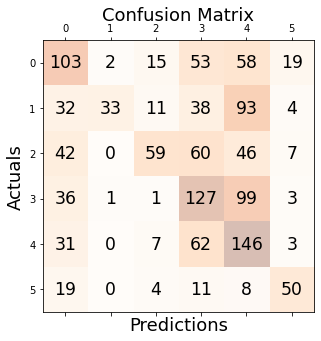

In [ ]:
conf_mat = confusion_matrix(np.argmax(y_test_six_way, axis=1), np.argmax(predict, axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#Glove Embeddings

In [71]:
x_train_glove.shape, x_val_glove.shape, x_test_glove.shape

((10269, 6), (1284, 6), (1283, 6))

In [100]:
def standardize(data):
  for d in range(len(data)):
    here = np.vectorize(lambda x: np.array(x)[:40])(data[d])
    # if here.shape[0] < 40:
    print(here.shape)

  # return data

In [ ]:
x_train_glove

In [102]:
b = np.zeros([len(x_train_glove),len(max(x_train_glove,key = lambda x: len(x)))])
for i,j in enumerate(x_train_glove):
    b[i][0:len(j)] = j

ValueError: ignored

In [ ]:
model = createHexaModel(x_train_glove)

In [ ]:
history = model.fit(x_train_glove, y_train_six_way, validation_data=[x_val_glove, y_val_six_way], epochs=10)

In [ ]:
predict = model.predict(x_test_glove)

In [ ]:
predict.shape, y_test_binary.shape

((1283, 6), (1283, 6))

In [ ]:
print('Accuracy score')
accuracy_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))

0.40374123148869834

In [ ]:
print('F1 score')
f1_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1), average='macro')

F1 score


0.40645462848062985

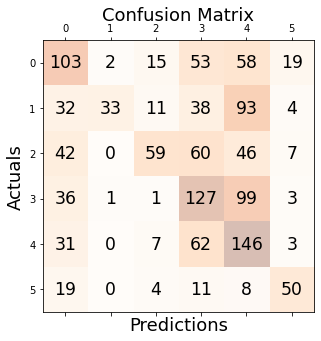

In [ ]:
conf_mat = confusion_matrix(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Binary Classification

## Preprocessing

In [37]:
num_classes = 2

In [38]:
# Function for preprocessing labels
def dataPreprocessingBinary(data):
    y = data["label"].tolist()

    # Changing the 'half-true', 'mostly-true', barely-true', 'pants-fire' labels to True/False for Binary Classification
    for x in range(len(y)):
        if(y[x] == 'half-true'):
            y[x] = 'True'
        elif(y[x] == 'mostly-true'):
            y[x] = 'True'
        elif(y[x] == 'barely-true'):
            y[x] = 'False'
        elif(y[x] == 'pants-fire'):
            y[x] = 'False'

    # Converting the lables into binary class matrix
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)
    y = np_utils.to_categorical(y, num_classes)
    return y

In [39]:
y_train_binary = dataPreprocessingBinary(train)
y_test_binary = dataPreprocessingBinary(test)
y_val_binary = dataPreprocessingBinary(val)

## Model
Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


In [ ]:
## write your code here
# Initialize hyperparameters

# Create model
# train
# test
# report accuracy, f1-score and confusion matrix

In [44]:
def createBinaryModel(input_sample):
  model = keras.Sequential()
  model.add(keras.layers.Embedding(input_sample.shape[0], 50, input_length=input_sample.shape[1])) # , batch_size=batch_size
  model.add(keras.layers.LSTM(64))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(2, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

#Bag of words

In [45]:
x_train_bow.shape, x_val_bow.shape, x_test_bow.shape

((10269, 8005), (1284, 8005), (1283, 8005))

In [46]:
model = createBinaryModel(x_train_bow)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:

In [47]:
history = model.fit(x_train_bow, y_train_binary, validation_data=[x_val_bow, y_val_binary], epochs=10)

Streaming output truncated to the last 5000 lines.
184/321 [================>.............] - ETA: 1:44 - loss: 0.5103 - accuracy: 0.7232Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_4332 in device /job:localhost/replica:0/task:0/device:GPU:0
185/321 [================>.............] - ETA: 1:44 - loss: 0.5105 - accuracy: 0.7231Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_4332 in device /job:localhost/replica:0/task:0/device:GPU:0
186/321 [================>.............] - ETA: 1:43 - loss: 0.5102 - accuracy: 0.7231Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

In [48]:
history.history

{'accuracy': [0.5784399509429932,
  0.6121336221694946,
  0.6991917490959167,
  0.7128250002861023,
  0.7180835604667664,
  0.7236342430114746,
  0.7262635231018066,
  0.7300613522529602,
  0.7337617874145508,
  0.7292823195457458],
 'loss': [0.6760259866714478,
  0.6430615186691284,
  0.5299225449562073,
  0.5167521238327026,
  0.5124291181564331,
  0.5080481767654419,
  0.5060237646102905,
  0.5041138529777527,
  0.5020485520362854,
  0.503802478313446],
 'val_accuracy': [0.5623052716255188,
  0.663551390171051,
  0.6713395714759827,
  0.704828679561615,
  0.6845794320106506,
  0.7118380069732666,
  0.7102803587913513,
  0.7133956551551819,
  0.7110592126846313,
  0.7102803587913513],
 'val_loss': [0.6743810176849365,
  0.5474200248718262,
  0.5279218554496765,
  0.508917510509491,
  0.5148488283157349,
  0.5040562748908997,
  0.5077846646308899,
  0.5079941749572754,
  0.5031665563583374,
  0.5057650208473206]}

In [49]:
predict = model.predict(x_test_bow)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

In [ ]:
predict.shape

(1283, 6)

In [ ]:
accuracy_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))

0.4271239282930631

In [ ]:
print('Accuracy score')
accuracy_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))

0.40374123148869834

In [ ]:
print('F1 score')
f1_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1), average='macro')

F1 score


0.40645462848062985

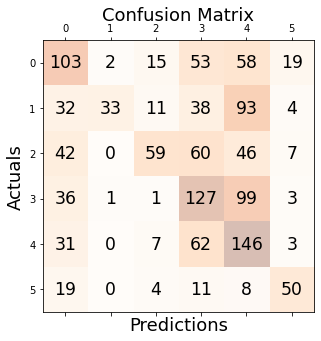

In [ ]:
conf_mat = confusion_matrix(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#Bert embeddings

In [50]:
x_train_bert.shape, x_val_bert.shape, x_test_bert.shape

NameError: ignored

In [ ]:
model = createBinaryModel(x_train_bert)

In [ ]:
history = model.fit(x_train_bert, y_train_binary, validation_data=[x_val_bert, y_val_binary], epochs=10)

In [ ]:
# dir(history)

In [ ]:
history.params

{'epochs': 10, 'steps': 321, 'verbose': 1}

In [ ]:
predict = model.predict(x_test_bert)

In [ ]:
predict.shape, y_test_binary.shape

((1283, 6), (1283, 6))

In [ ]:
print('Accuracy score')
accuracy_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))

0.40374123148869834

In [ ]:
print('F1 score')
f1_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1), average='macro')

F1 score


0.40645462848062985

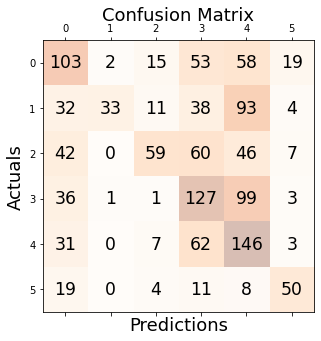

In [ ]:
conf_mat = confusion_matrix(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#Glove Embeddings

In [60]:
x_train_glove.shape, x_val_glove.shape, x_test_glove.shape

((10269, 8005), (1284, 8005), (1283, 8005))

In [61]:
model = createBinaryModel(x_train_glove)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:

In [62]:
history = model.fit(x_train_glove, y_train_binary, validation_data=[x_val_glove, y_val_binary], epochs=10)

Streaming output truncated to the last 5000 lines.
184/321 [================>.............] - ETA: 1:45 - loss: 0.5151 - accuracy: 0.7108Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_23422 in device /job:localhost/replica:0/task:0/device:GPU:0
185/321 [================>.............] - ETA: 1:44 - loss: 0.5150 - accuracy: 0.7110Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_23422 in device /job:localhost/replica:0/task:0/device:GPU:0
186/321 [================>.............] - ETA: 1:44 - loss: 0.5152 - accuracy: 0.7107Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

In [ ]:
predict = model.predict(x_test_glove)

In [ ]:
predict.shape, y_test_binary.shape

((1283, 6), (1283, 6))

In [ ]:
print('Accuracy score')
accuracy_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))

0.40374123148869834

In [ ]:
print('F1 score')
f1_score(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1), average='macro')

F1 score


0.40645462848062985

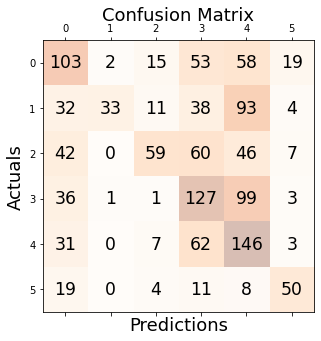

In [ ]:
conf_mat = confusion_matrix(np.argmax(y_test_binary, axis=1), np.argmax(predict, axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()